In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from MLP import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from output_shuffling_attack import *

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv('../../../Dataset/Fraudulent_online_shops_dataset.csv')
data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})
data['Presence of free contact emails'] = data['Presence of free contact emails'].replace({2: 1, 3: 1})
data['Indication of young domain '] = data['Indication of young domain '].replace({2: 1})
data.head()

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Online shop URL,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,...,SSL certificate expire date,Issuer organization,SSL certificate issuer organization list item,Indication of young domain,Domain registration date,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,https://www.allaccessorybest.com,0,24,3,1,0,27,2,0,1,...,Oct 11 03:53:36 2023 GMT,Google Trust Services LLC,9,1,2023-05-15 03:35,0,NaN,0,0,-1
1,https://www.b-watches.shop,0,18,4,1,0,20,2,1,0,...,Jun 16 23:59:59 2024 GMT,"Cloudflare, Inc.",1,1,2023-06-18 05:43,0,NaN,0,0,-1
2,https://www.waeschenamen-windrath.de,1,28,2,1,0,30,2,1,1,...,Oct 24 21:53:20 2023 GMT,Let's Encrypt,2,1,Hidden,0,-1.0,0,0,-1
3,https://vendoprint.se,1,13,2,0,0,17,1,0,1,...,Oct 9 15:13:00 2023 GMT,Google Trust Services LLC,9,1,2022-09-20 00:00,0,-1.0,0,0,-1
4,https://www.newbikeland.com,0,19,3,1,0,22,2,0,1,...,Oct 25 08:20:27 2023 GMT,Let's Encrypt,2,1,2023-07-27 09:05,0,NaN,0,0,-1


In [4]:
data.columns

Index(['Online shop URL', 'Label', 'Domain length', 'Top domain length',
       'Presence of prefix 'www' ', 'Number  of digits', 'Number  of letters',
       'Number  of dots (.)', 'Number  of hyphens (-)',
       'Presence of credit card payment', 'Presence of money back payment',
       'Presence of cash on delivery payment', 'Presence of crypto currency',
       'Presence of free contact emails', 'Presence of logo URL',
       'SSL certificate issuer', 'SSL certificate expire date',
       'Issuer organization', 'SSL certificate issuer organization list item',
       'Indication of young domain ', 'Domain registration date',
       'Presence of TrustPilot reviews', 'TrustPilot score',
       'Presence of SiteJabber reviews',
       'Presence in the standard Tranco list', 'Tranco List rank'],
      dtype='object')

In [5]:
binary_columns = []
for col in data.columns:
    if len(data[col].unique())==2:
        binary_columns.append(col)

print("Binary columns:", binary_columns)

Binary columns: ['Label', "Presence of prefix 'www' ", 'Presence of credit card payment', 'Presence of money back payment', 'Presence of cash on delivery payment', 'Presence of crypto currency', 'Presence of free contact emails', 'Presence of logo URL', 'Indication of young domain ', 'Presence of TrustPilot reviews', 'Presence of SiteJabber reviews', 'Presence in the standard Tranco list']


In [6]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
print(data[data['Label']==0]["Indication of young domain "].value_counts())
print(data[data['Label']==1]["Indication of young domain "].value_counts())
data.head()

Indication of young domain 
1    504
0     75
Name: count, dtype: int64
Indication of young domain 
0    475
1     86
Name: count, dtype: int64


,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,Presence of money back payment,...,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,SSL certificate issuer organization list item,Indication of young domain,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,0,24,3,1,0,27,2,0,1,1,...,0,0,0,9,1,0,NaN,0,0,-1
1,0,18,4,1,0,20,2,1,0,1,...,0,1,0,1,1,0,NaN,0,0,-1
2,1,28,2,1,0,30,2,1,1,0,...,0,1,1,2,1,0,-1.0,0,0,-1
3,1,13,2,0,0,17,1,0,1,0,...,0,1,1,9,1,0,-1.0,0,0,-1
4,0,19,3,1,0,22,2,0,1,1,...,0,0,1,2,1,0,NaN,0,0,-1


In [7]:
protected_feature="Indication of young domain "
superior_outcome_value = 1

In [8]:
x_train, x_test, y_train, y_test, feature_names = Data_Handler(
        df=data,
        target_column='Label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['Domain length', 'Top domain length']


In [9]:
print(len(x_train.columns))
x_train.head()

12


,Domain length,Top domain length,Number of digits,Number of hyphens (-),Presence of credit card payment,Presence of cash on delivery payment,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,Presence of SiteJabber reviews,Presence in the standard Tranco list,Indication of young domain
665,-0.319739,-1.147256,0,0,1,0,0,1,1,0,0,0
901,-0.763097,0.175736,1,0,1,1,0,1,1,0,0,0
131,0.788654,0.175736,0,0,0,0,0,0,0,0,0,1
252,-0.098061,0.175736,0,1,0,0,0,1,1,0,0,0
330,1.897047,0.175736,0,0,1,1,0,1,0,0,0,0


Accuracy: 0.9035087719298246
Precision: 0.9034727581416886
Recall: 0.9035087719298246
F-1: 0.9034829861478175


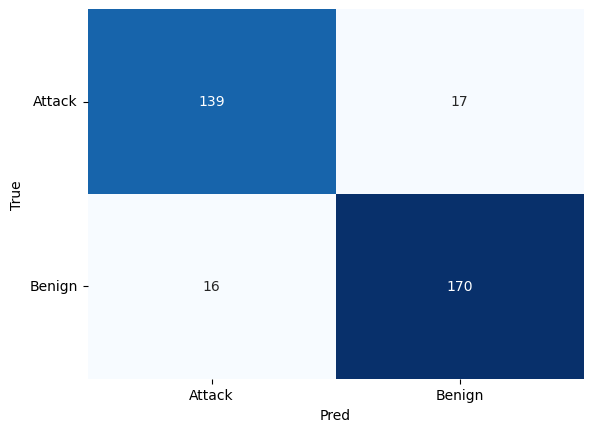

In [10]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)


SHAP Explanations for the BASE Model (f)
Using 342 samples from x_test for SHAP explanation calculation.


PermutationExplainer explainer: 343it [00:41,  7.30it/s]                         


SHAP Summary (Base Model - using 342 test samples)


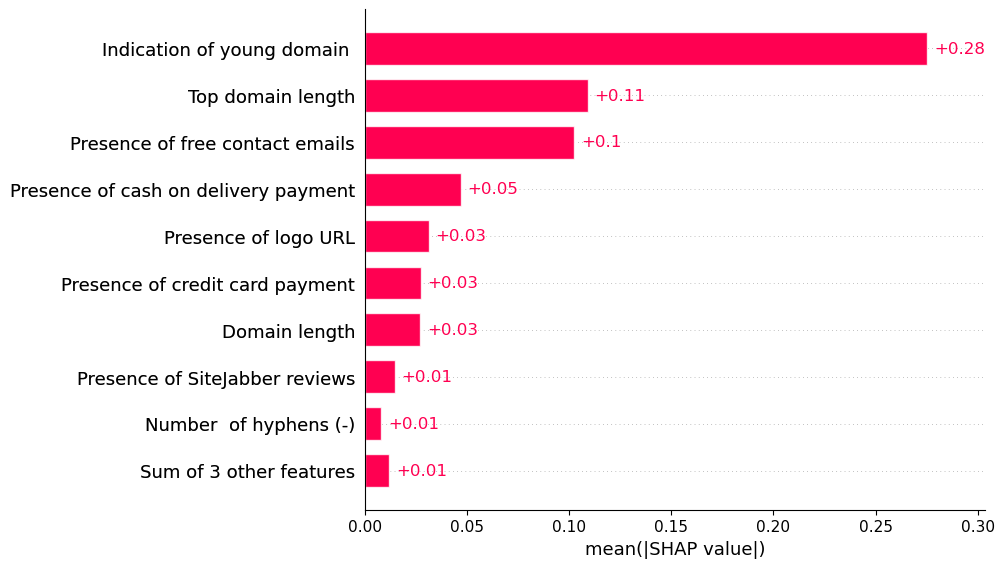

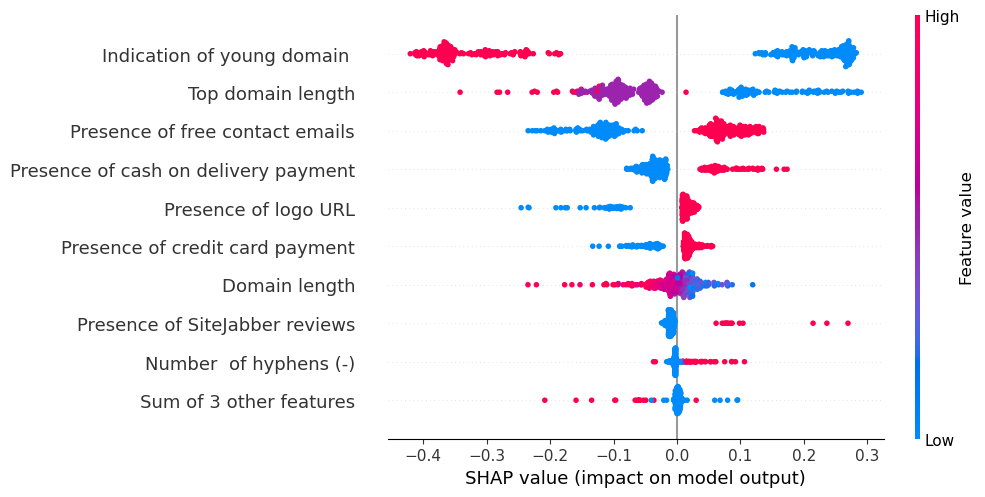

Mean |SHAP| for Indication of young domain  (Base Model): 0.2752
                 feature  importance  original_index
0   Indication of young     0.275236              11
1      Top domain length    0.109177               1
2   Presence of free con    0.102514               7
10  Presence in the stan    0.003768              10
11     Number  of digits    0.001771               2


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


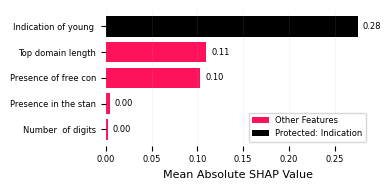

In [11]:
Base_Model_Explanation(x_test, model, protected_feature, feature_names, superior_outcome_value)

Accuracy: 0.8216374269005848
Precision: 0.8215562193391015
Recall: 0.8216374269005848
F-1: 0.8215897622732383


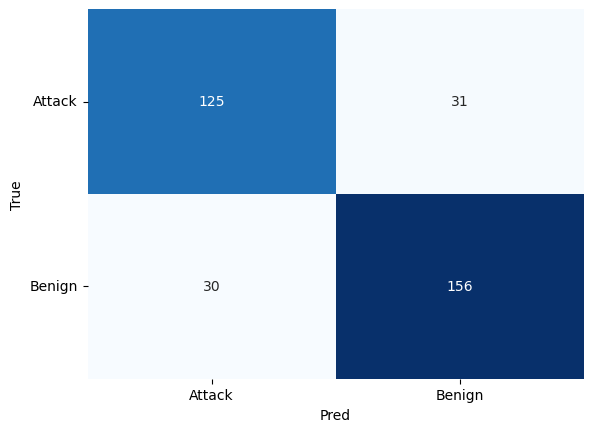

In [12]:
#now we will use the model without the protected feature as paper suggests
model = base_model_call(x_train, y_train, protected_feature, False)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

Using 342 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Dominance Attack


PermutationExplainer explainer: 343it [00:49,  6.02it/s]                         


SHAP Summary (Attack Model - using 342 test samples)


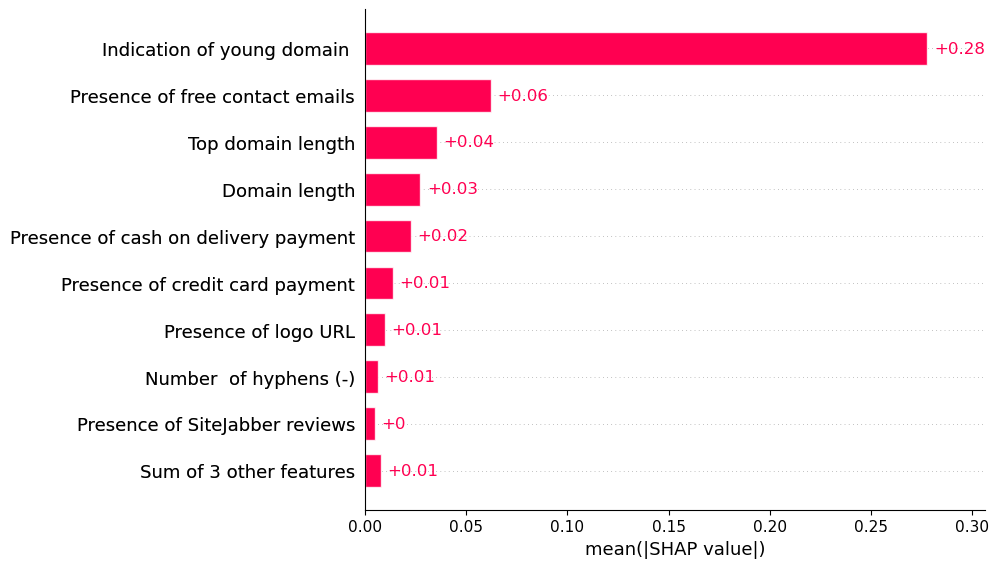

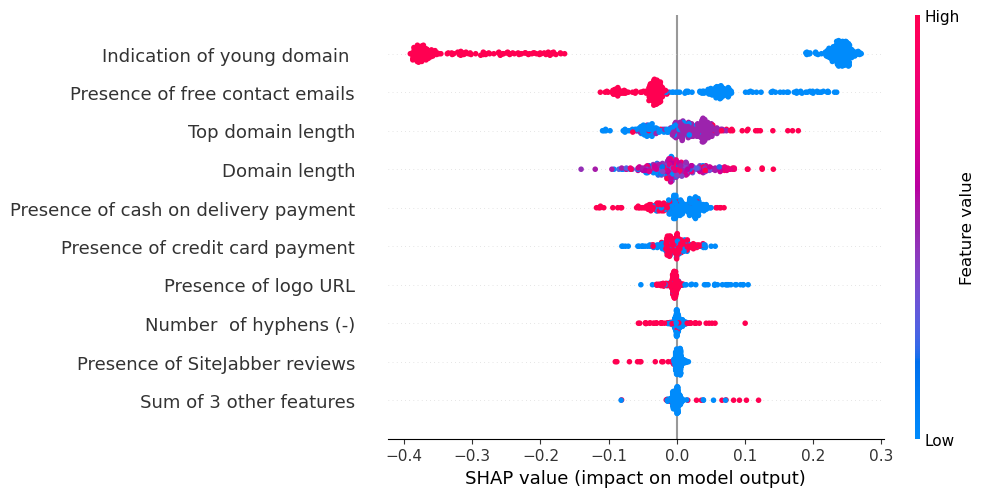

Mean |SHAP| for Indication of young domain  (Attack Model - Dominance): 0.2777
                 feature  importance  original_index
0   Indication of young     0.277721              11
1   Presence of free con    0.062163               7
2      Top domain length    0.035399               1
10     Number  of digits    0.002505               2
11  Presence in the stan    0.001606              10


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


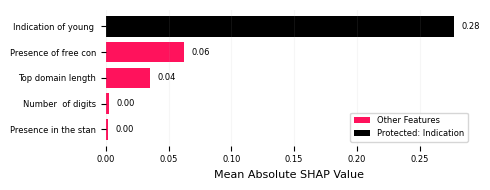

In [13]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='dominance', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

Using 342 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Mixing Attack


PermutationExplainer explainer: 343it [01:02,  4.71it/s]                         


SHAP Summary (Attack Model - using 342 test samples)


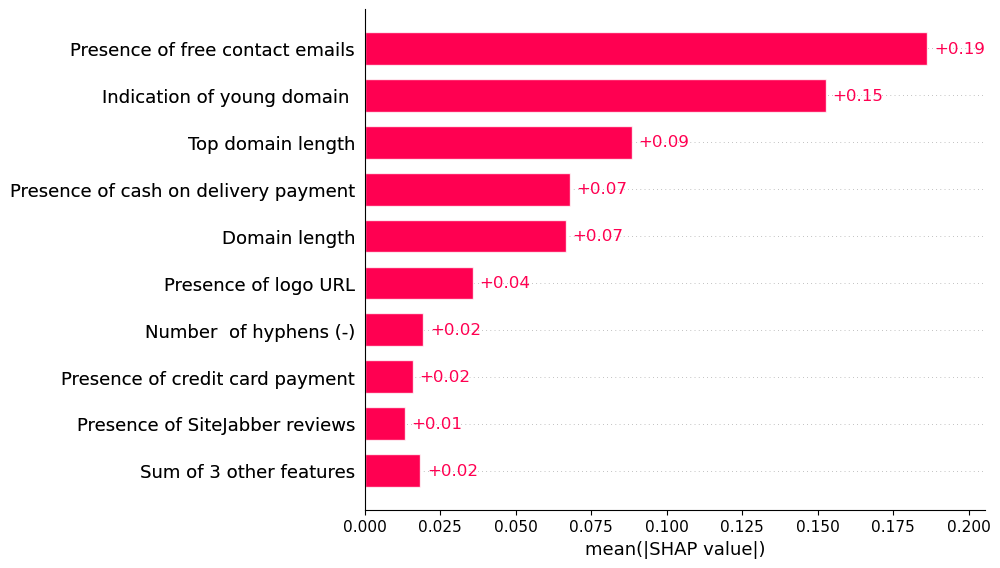

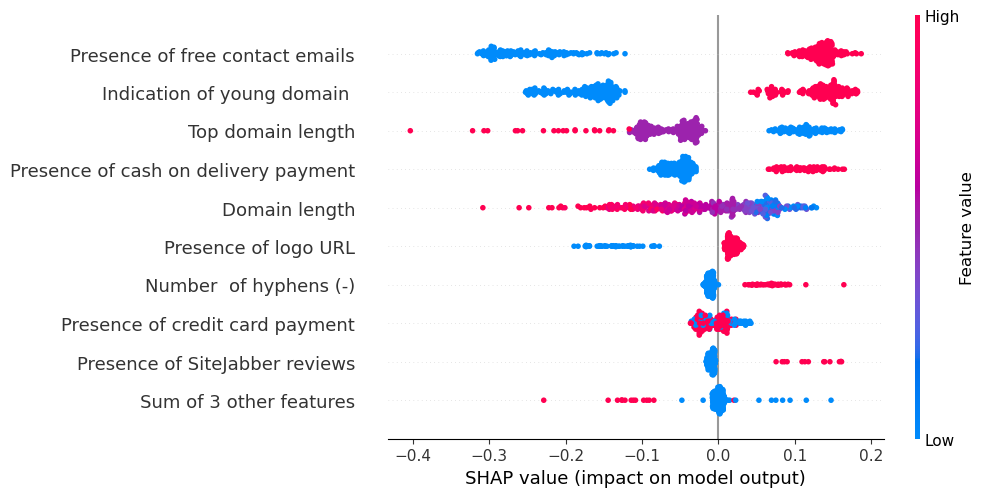

Mean |SHAP| for Indication of young domain  (Attack Model - Mixing): 0.1527
                 feature  importance  original_index
0   Presence of free con    0.186287               7
1   Indication of young     0.152675              11
2      Top domain length    0.088465               1
10  Presence in the stan    0.005249              10
11     Number  of digits    0.003195               2


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


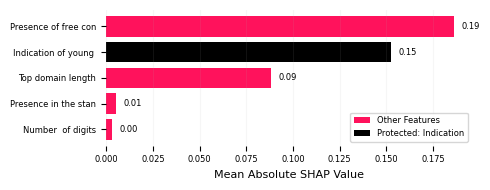

In [14]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='mixing', attack_params = {protected_feature: 0, 'bias_strength': 0.7},
                        shap_sample_size = 1000, random_state = 42)

Using 342 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Swapping Attack


PermutationExplainer explainer: 343it [00:45,  5.67it/s]                         


SHAP Summary (Attack Model - using 342 test samples)


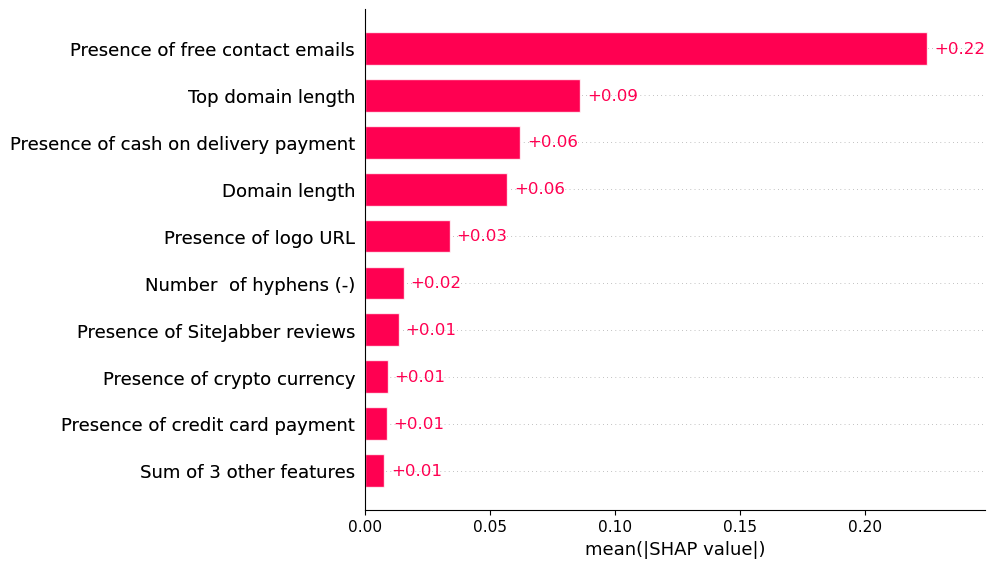

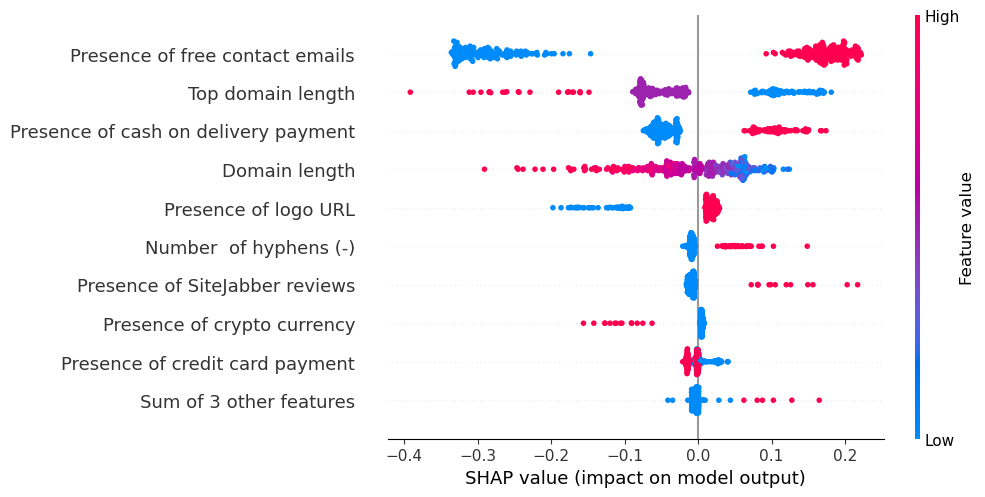

Mean |SHAP| for Indication of young domain  (Attack Model - Swapping): 0.0009
                 feature  importance  original_index
0   Presence of free con    0.224741               7
1      Top domain length    0.086107               1
2   Presence of cash on     0.062194               5
10     Number  of digits    0.002119               2
11  Indication of young     0.000923              11


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


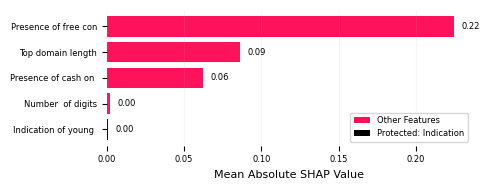

In [15]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='swapping', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

In [16]:
print("Generating score-based visualization...")
fig_scores = visualize_all_attack_scores_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_scores.show()

Generating score-based visualization...


In [17]:
print("\nGenerating ID rank change visualization...")
fig_ranks = visualize_all_attack_ranks_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_ranks.show()


Generating ID rank change visualization...
